In January 2020, I moved back to my home country, Cyprus, to take a Lecturer position at Cyprus University of Technology. Six weeks into the new job, COVID19 hit, and I started working from home. During the lockdown, many countries reported a [rapid decrease in electricity consumption](https://www.bruegel.org/2020/03/covid-19-crisis-electricity-demand-as-a-real-time-indicator/) and a change in the consumption patterns. Since the Transmission System Operator in Cyprus publishes good-quality data on their [website](https://tsoc.org.cy/), I decided to check what was happening with the electricity load consumption. It was an excellent opportunity for me to look into the load data of Cyprus, and refresh my (minimal) pandas skills. A media article came out of it, and if you are Greek-speaking, you can find it [here](https://www.sigmalive.com/news/oikonomia/626432/i-epidrasi-tou-koronoiou-stin-energeiaki-symperifora-ton-kyprion).

This blog post is based on the Jupyter notebook I used to do the data analysis and is more focused on the analysis rather than the impact of COVID19 on Cyprus. Aka is more a scripting exercise rather than a techno-socio-economic study. I've uploaded this notebook and the accompanying ones at [this repository]().

## Getting and loading the data

First thing, I headed to the [TSOC website](https://tsoc.org.cy/) and downloaded the data for the 8 weeks I'm interested in 2019 and 2020. Since the TSO only provides data in 15-day intervals, I built a data scraping script (*power_data_scrap*) to automatically download data within a range and included it in the repository. I also got data from https://www.degreedays.net/ for the Heating Degree Days (HDD) to relate the load change to the heating requirements. This website allows to download up to 3 years back data, so I just downloaded directly.

Then, I built a script that reads the data for the Excel/CSV files into pandas DFs (*import_data*). This script calls the data scraper to update the data and returns four DFs : *df19*, *df20*, *dfHDD19*, and *dfHDD20*. The first two include generation profiles, and the last two include the weekly HDDs, for 2019 and 2020 respectively.

In [1]:
%run ./import_data.ipynb

## Initialise and preprocess data

Once I have the four DFs in this notebook, I need to preprocess them a bit. The steps I take are:
1. Take a backup and filter out the weeks of the year I'm interested in. Since the lockdown started on week 12 of 2020, I started from week 10 and up to 2 months later. The backup/restore functions I used to avoid calling *import_data* every time I did something wrong in the code.
2. I shift the 2019 DFs by 364 days to align the workdays of the two years for better comparison. It was not really needed when working with weekly values, but at some point, I made day-to-day comparisons.
3. I merge the yearly, shifted load profiles in a single DF and the HDD profiles in another. Again, this makes it easier, later on, to plot with cufflinks, but still not strictly necessary.
4. I create two filtered DFs (df19wd and df20wd), where I have removed weekends and public holidays. I have a text file with the 2019 and 2020 public holidays [here](https://github.com/SPS-L/public-files-and-scripts/blob/master/Cyprus-public-holidays.txt).

In [2]:
# The pre-processing below is messy. There are probably faster ways 
# to get everything in place. I'll revisit when I have more experience with pandas

# We define the weeks we will analyse. startweek is two week before our focusweek to get the trend
startweek = 10
focusweek = 12
endweek = 18

# Make backup of the DB for 2019 and 2020 for the comparison weeks only
df19_init = df19[(df19.index.weekofyear >= startweek) & (df19.index.weekofyear <= endweek)].copy()
df20_init = df20[(df20.index.weekofyear >= startweek) & (df20.index.weekofyear <= endweek)].copy()
dfHDD19_init = dfHDD19[(dfHDD19.index.weekofyear >= startweek) & (dfHDD19.index.weekofyear <= endweek)].copy()
dfHDD20_init = dfHDD20[(dfHDD20.index.weekofyear >= startweek) & (dfHDD20.index.weekofyear <= endweek)].copy()

In [3]:
# Restore from backup. Restart here in case we just made a code mistake.
df19 = df19_init.copy()
df20 = df20_init.copy()
dfHDD19 = dfHDD19_init.copy()
dfHDD20 = dfHDD20_init.copy()

In [4]:
# We shift the 2019 data to match the ones of 2020 to align workdays
df19["Datetime"] = pd.to_datetime(df19.index + timedelta(days=365-1))
df19.set_index('Datetime', inplace=True)
dfHDD19["Datetime"] = pd.to_datetime(dfHDD19.index + timedelta(days=365-1))
dfHDD19.set_index('Datetime', inplace=True)

# Now that the dataframes are aligned for both years, we merge into a single DF for easier comparison
df20["Datetime"] = pd.to_datetime(df20.index)
df20.set_index('Datetime', inplace=True)
alldf = df19[['LOAD19','PEN19']]
alldf = alldf.merge(df20[['LOAD20','PEN20']], left_index=True, right_index=True)

# Same for HDD, we merge into single aligned DF
allHDD = dfHDD20
allHDD.rename(columns={'HDD 15.5': 'HDD20'}, inplace=True)
allHDD['HDD19'] = dfHDD19['HDD 15.5'].copy()
# Generate new column with the HDD difference between years
allHDD['HDDDIFF'] = allHDD['HDD20'] - allHDD['HDD19']

In [5]:
holidaylist = ['2019-01-01','2019-01-06','2019-03-11','2019-03-25',
              '2019-04-01','2019-04-26','2019-04-29','2019-05-01',
              '2019-06-17','2019-08-15','2019-10-01','2019-10-28',
              '2019-12-24','2019-12-25','2019-12-26',
              '2020-01-01','2020-01-06','2020-03-02','2020-03-25',
              '2020-04-01','2020-04-17','2020-04-20','2020-05-01',
              '2020-06-08','2020-08-15','2020-10-01','2020-10-28',
              '2020-12-24','2020-12-25','2020-12-26'
              ]
df19wd = df19_init[[d.date() not in pd.to_datetime(holidaylist) for d in df19_init.index]].copy()
df19wd = df19wd[ (df19wd.index.weekday < 5) ]
df20wd = df20_init[[d.date() not in pd.to_datetime(holidaylist) for d in df20_init.index]].copy()
df20wd = df20wd[ (df20wd.index.weekday < 5) ]

## Initialise visualisation

The next step is to initialise the visualisation settings. I used cufflinks/plotly to do the visualisation, which is extremely powerful. However, I had a problem when embedding in my website, titles overrunning and figures not showing as they should on different platforms. So, I decided to generate the PNG files and insert them. There is a flag below to shift from interactive to PNG figures.

In [6]:
# Prepare the folder to save the images
import os
from IPython.display import Image, display
if not os.path.exists("images"):
    os.mkdir("images")
    
# Setting inPNG=true generates PNG images and embeds them.
# I found this better behaved rather than embedding the plotly ones in my website
inPNG = True
imheight = 450
imwidth = 900
imscale = 3

import cufflinks as cf
import plotly.offline
import plotly.graph_objects as go
import plotly.io as pio
import plotly.tools as tls
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True,theme='pearl')
cf.set_config_file(dimensions=(imwidth,imheight))

## Impact on average energy consumption

Now that everything is set up let's do some analysis. The first aspect we want to see is the average weekly load and how it has changed compared to last year. Fig. 1a shows the weekly average load, and we can see a clear decreasing trend right after the lockdown (week 12).

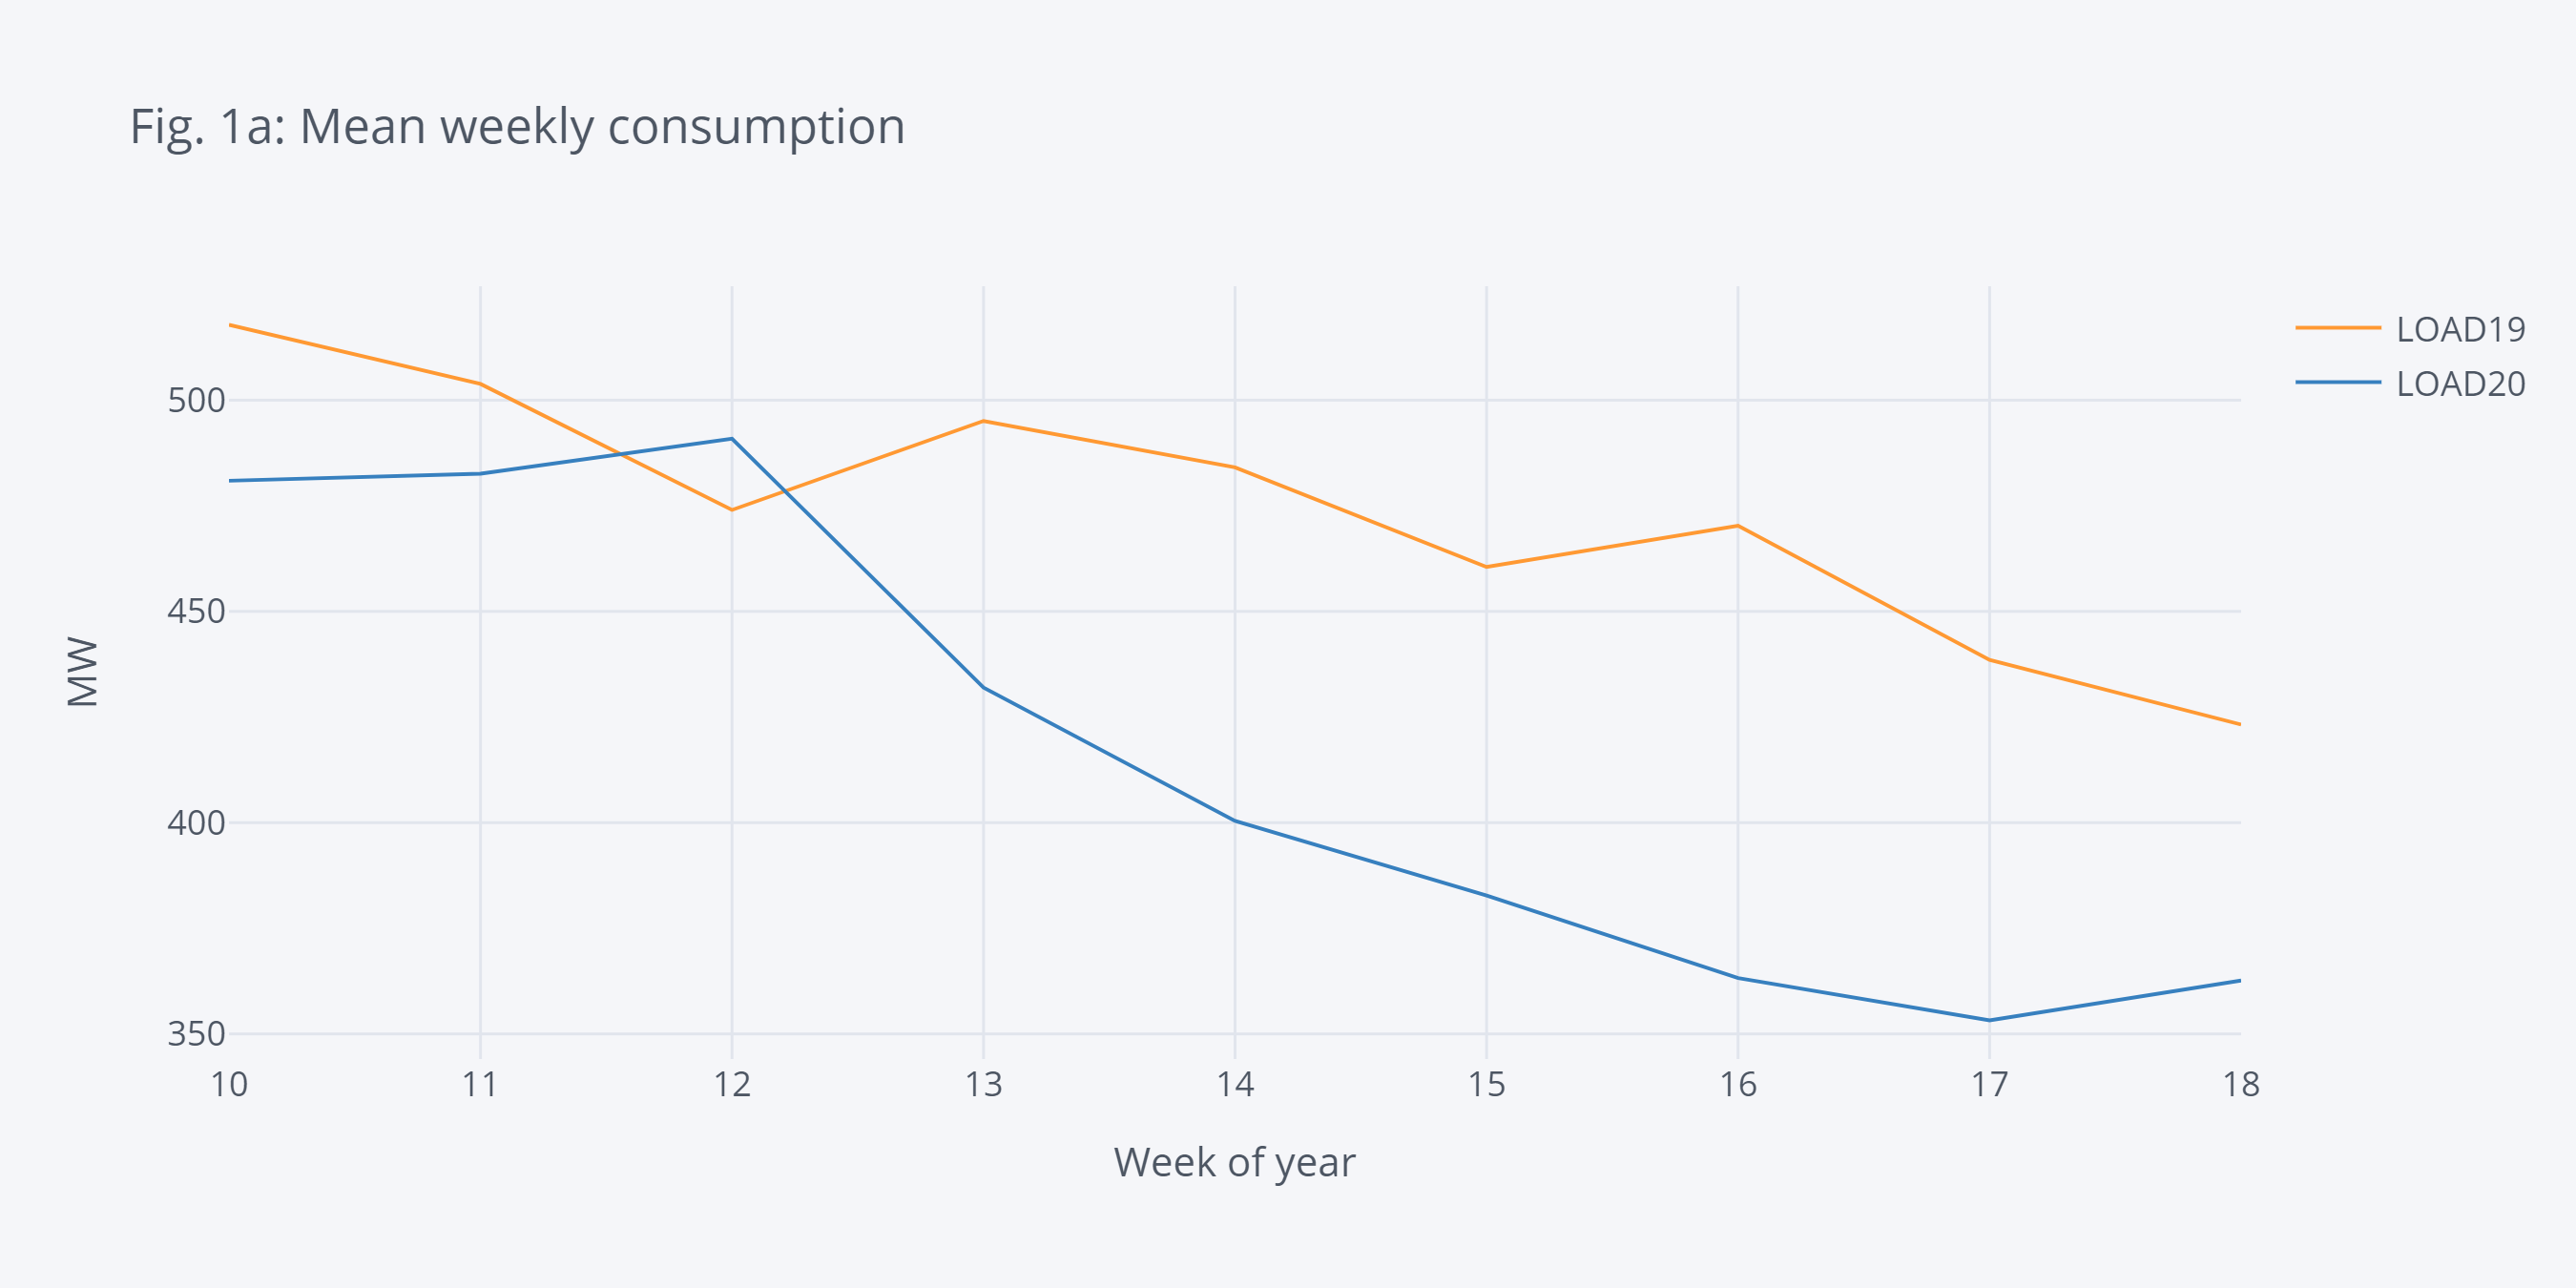

In [7]:
# Full week
alldfWmean = alldf.resample('W').mean()
alldfWmean['week'] = alldfWmean.index.weekofyear
alldfWmean.set_index('week', inplace=True)
fig = alldfWmean.iplot(asFigure = True, kind='line',y=['LOAD19','LOAD20'],xTitle='Week of year',yTitle='MW',title='Fig. 1a: Mean weekly consumption')
if inPNG:
    fig.write_image("images/fig1a.png", height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig1a.png"))
else:
    fig.show()

Fig. 1b shows the same but only for workdays and work hours (considered 8:00-18:00). It can be seen that we have the same decreasing trend.

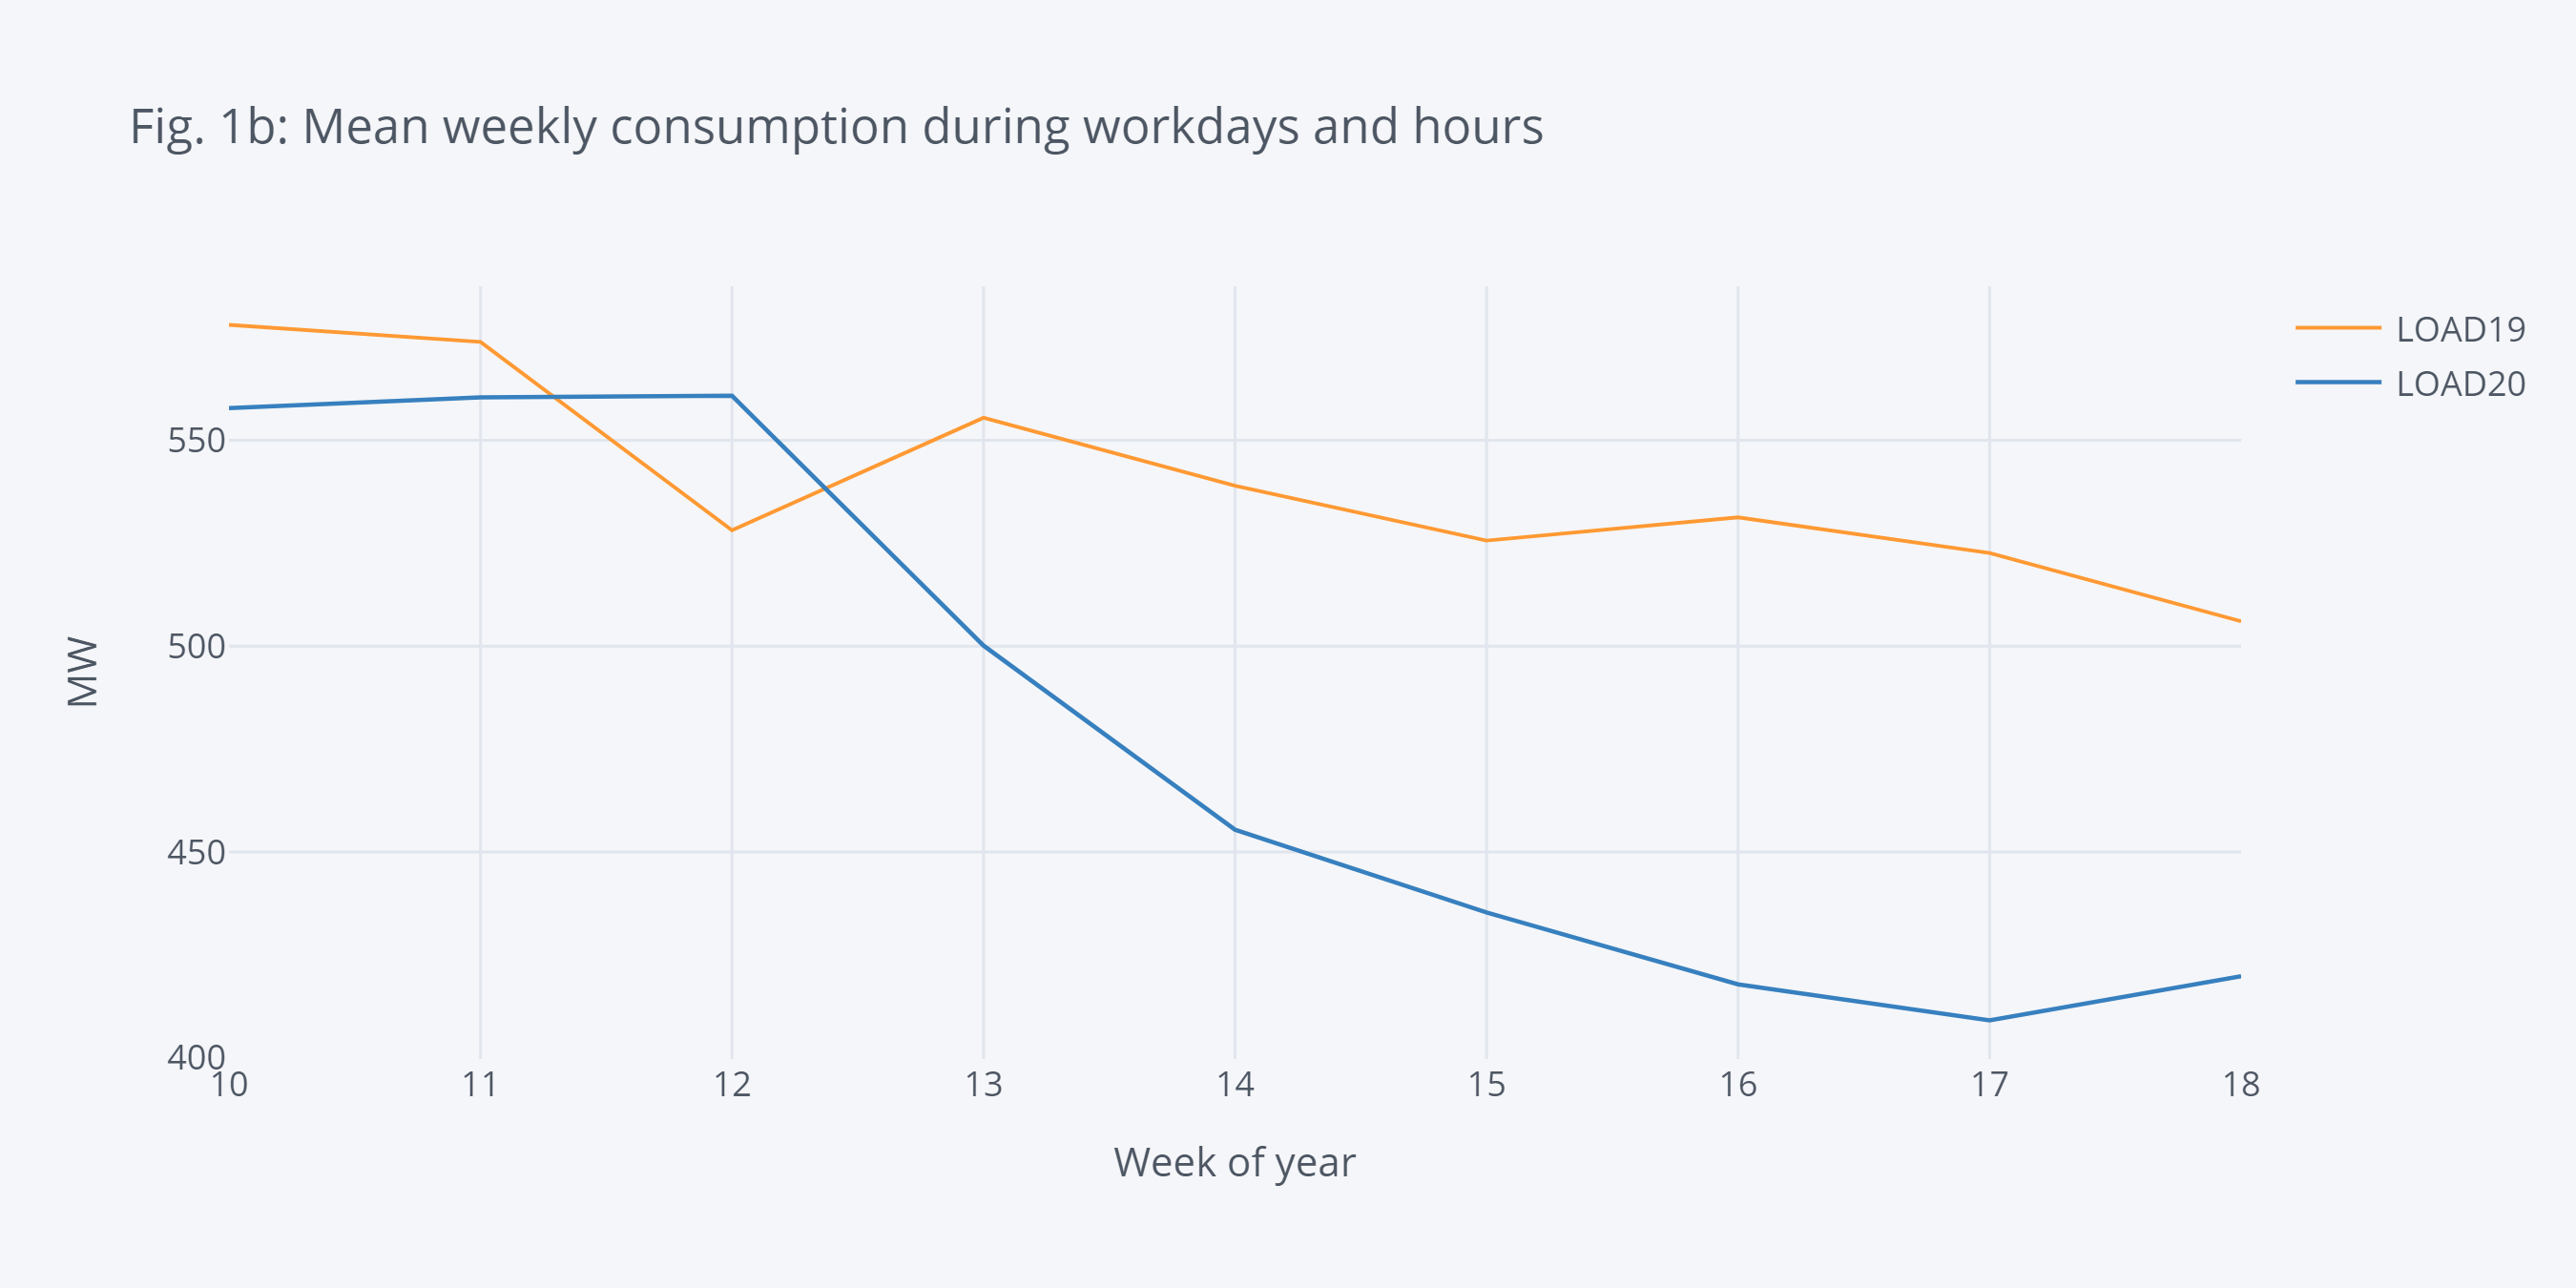

In [8]:
# This focuses on workdays and hours
# 2019
alldfWmean19 = df19wd[(df19wd.index.hour >= 8) & (df19wd.index.hour <= 18)].resample('W').mean()
alldfWmean19['week'] = alldfWmean19.index.weekofyear
alldfWmean19.set_index('week', inplace=True)
fig = alldfWmean19.iplot(asFigure = True, kind='line',y='LOAD19',xTitle='Week of year',yTitle='MW',title='Fig. 1b: Mean weekly consumption during workdays and hours')
# 2020
alldfWmean20 = df20wd[(df20wd.index.hour >= 8) & (df20wd.index.hour <= 18)].resample('W').mean()
alldfWmean20['week'] = alldfWmean20.index.weekofyear
alldfWmean20.set_index('week', inplace=True)
fig.add_trace(go.Scatter(x=alldfWmean20.index,y=alldfWmean20['LOAD20'], mode='lines',name='LOAD20',line=dict(width=1.5,color=cf.colors.hex_to_rgb('blue'))))

if inPNG:
    fig.write_image("images/fig1b.png", height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig1b.png"))
else:
    fig.show()

In Figs. 2a and 2b we can see the decrease more clearly as a percentage of the power in 2019. We observe an up to 20% decrease, which is comparable to the reduction seen in [many other European countries](https://infogram.com/electricity_line-1ho16v85mymx2nq) with Italy having the record decrease. The USA had a [similar drop](https://www.weforum.org/agenda/2020/04/united-states-eneregy-electricity-power-coronavirus-covid19/).

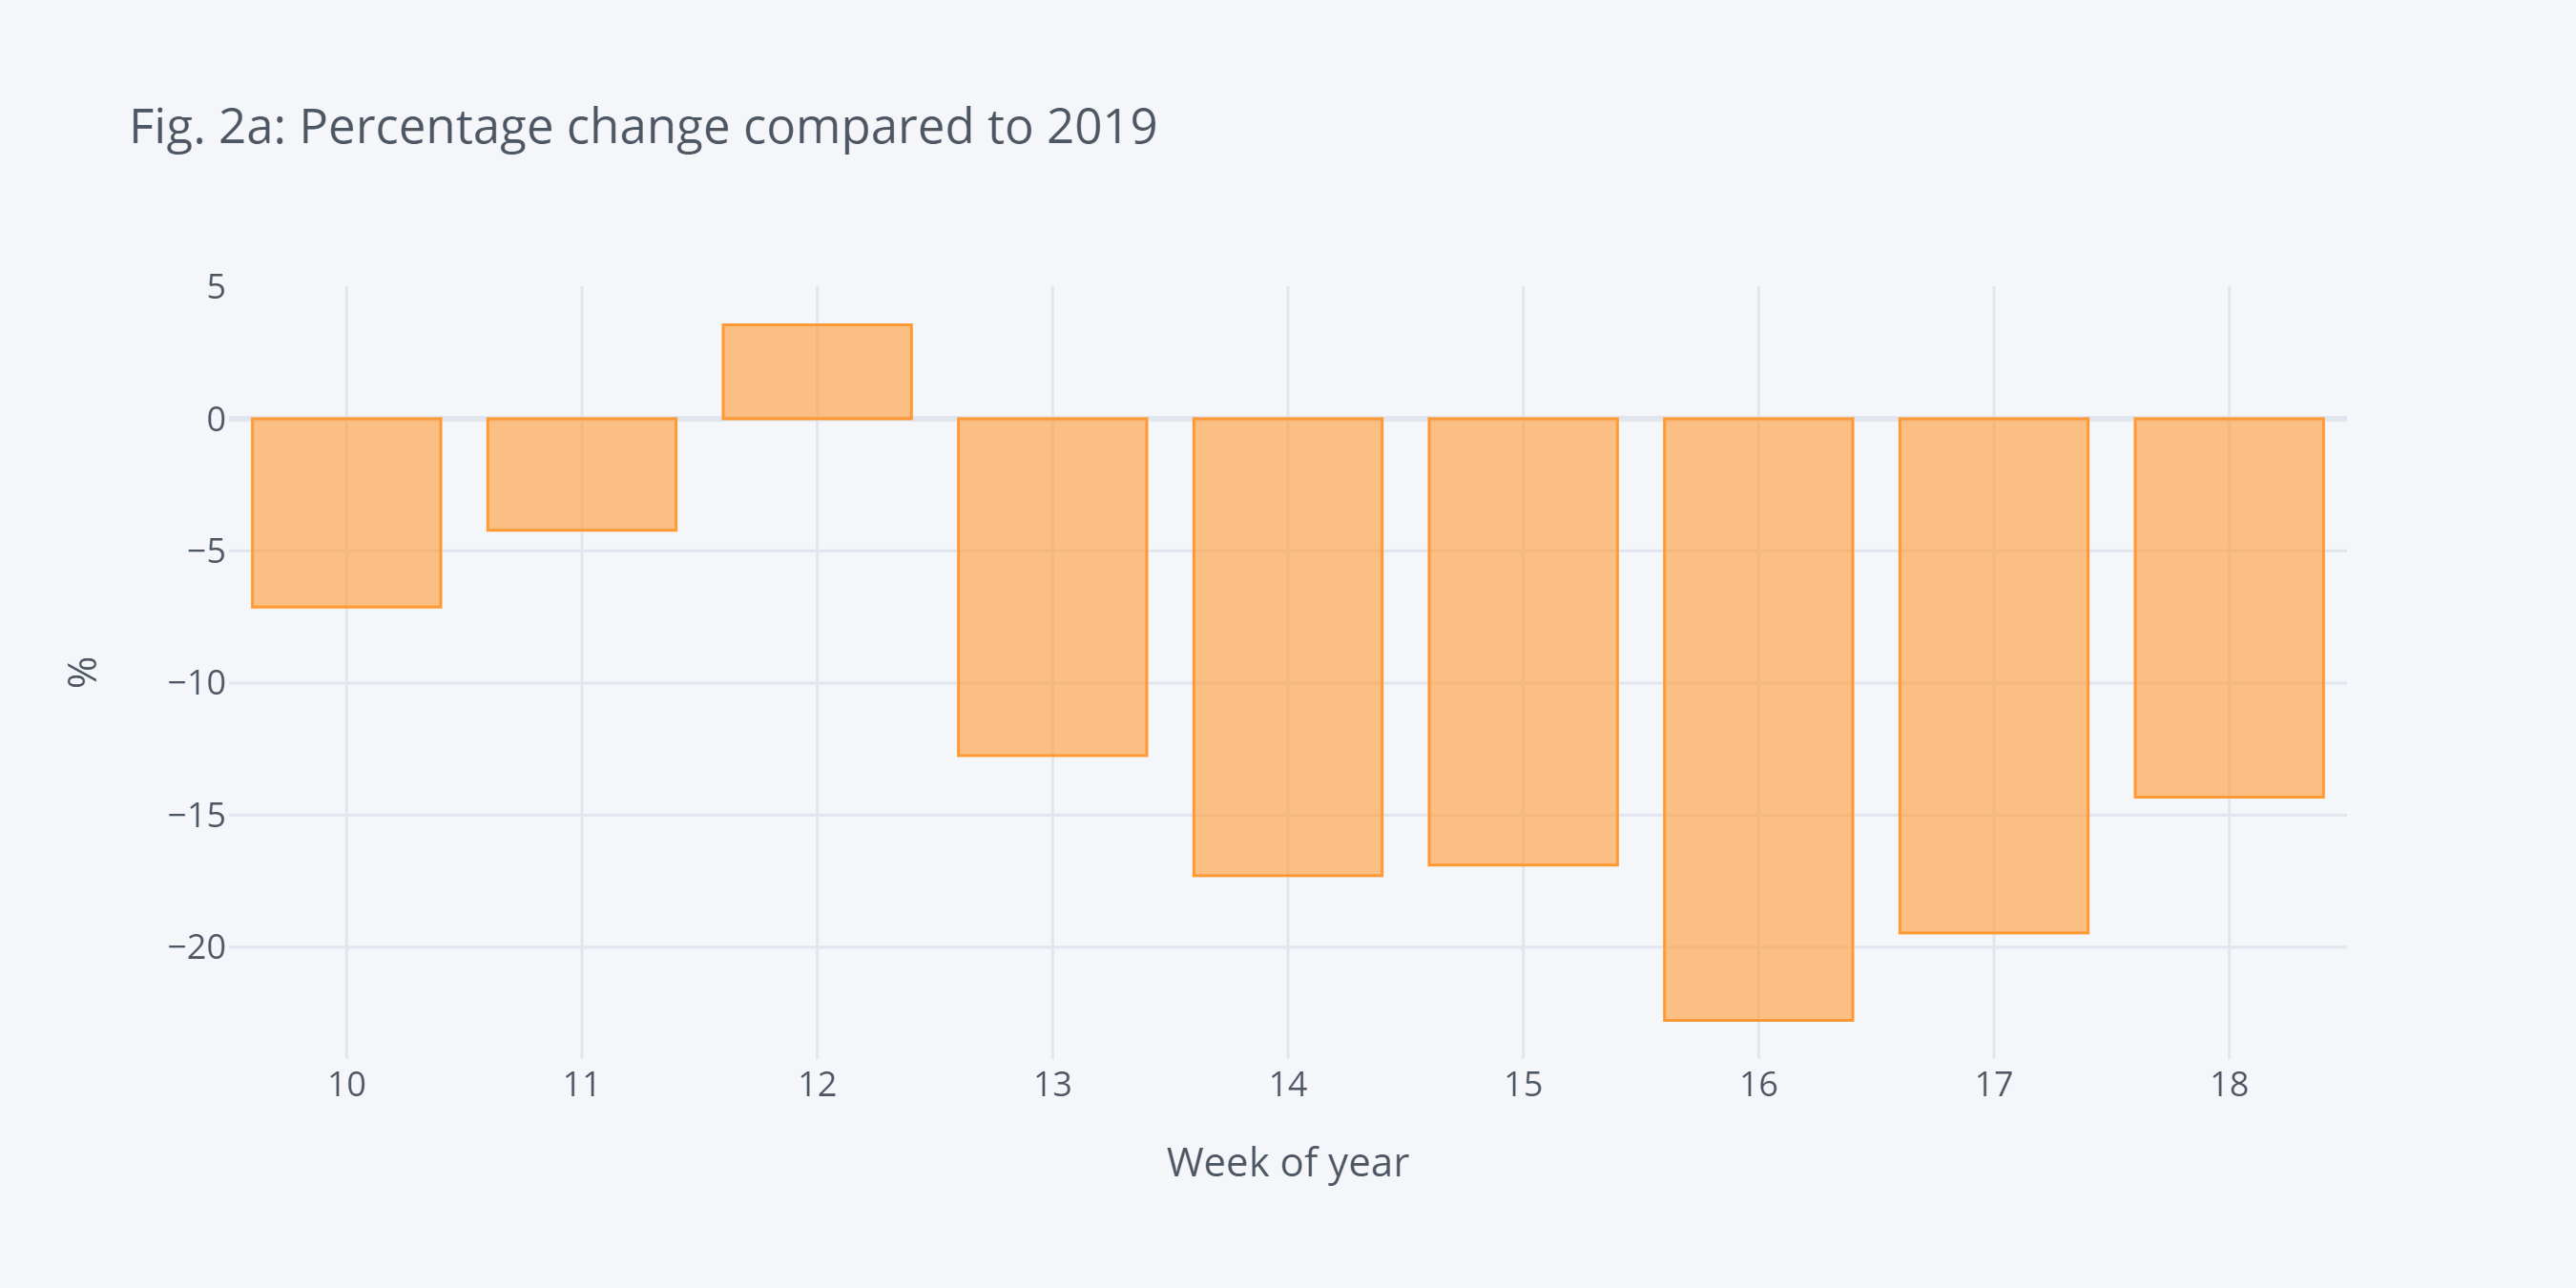

In [9]:
alldfWmean['perc'] = ((alldfWmean['LOAD20'] -alldfWmean['LOAD19']) / alldfWmean['LOAD19'])*100.0
fig = alldfWmean.iplot(asFigure = True, kind='bar',xTitle='Week of year',yTitle='%',y='perc',title='Fig. 2a: Percentage change compared to 2019')
if inPNG:
    fig.write_image("images/fig2a.png",height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig2a.png"))
else:
    fig.show()

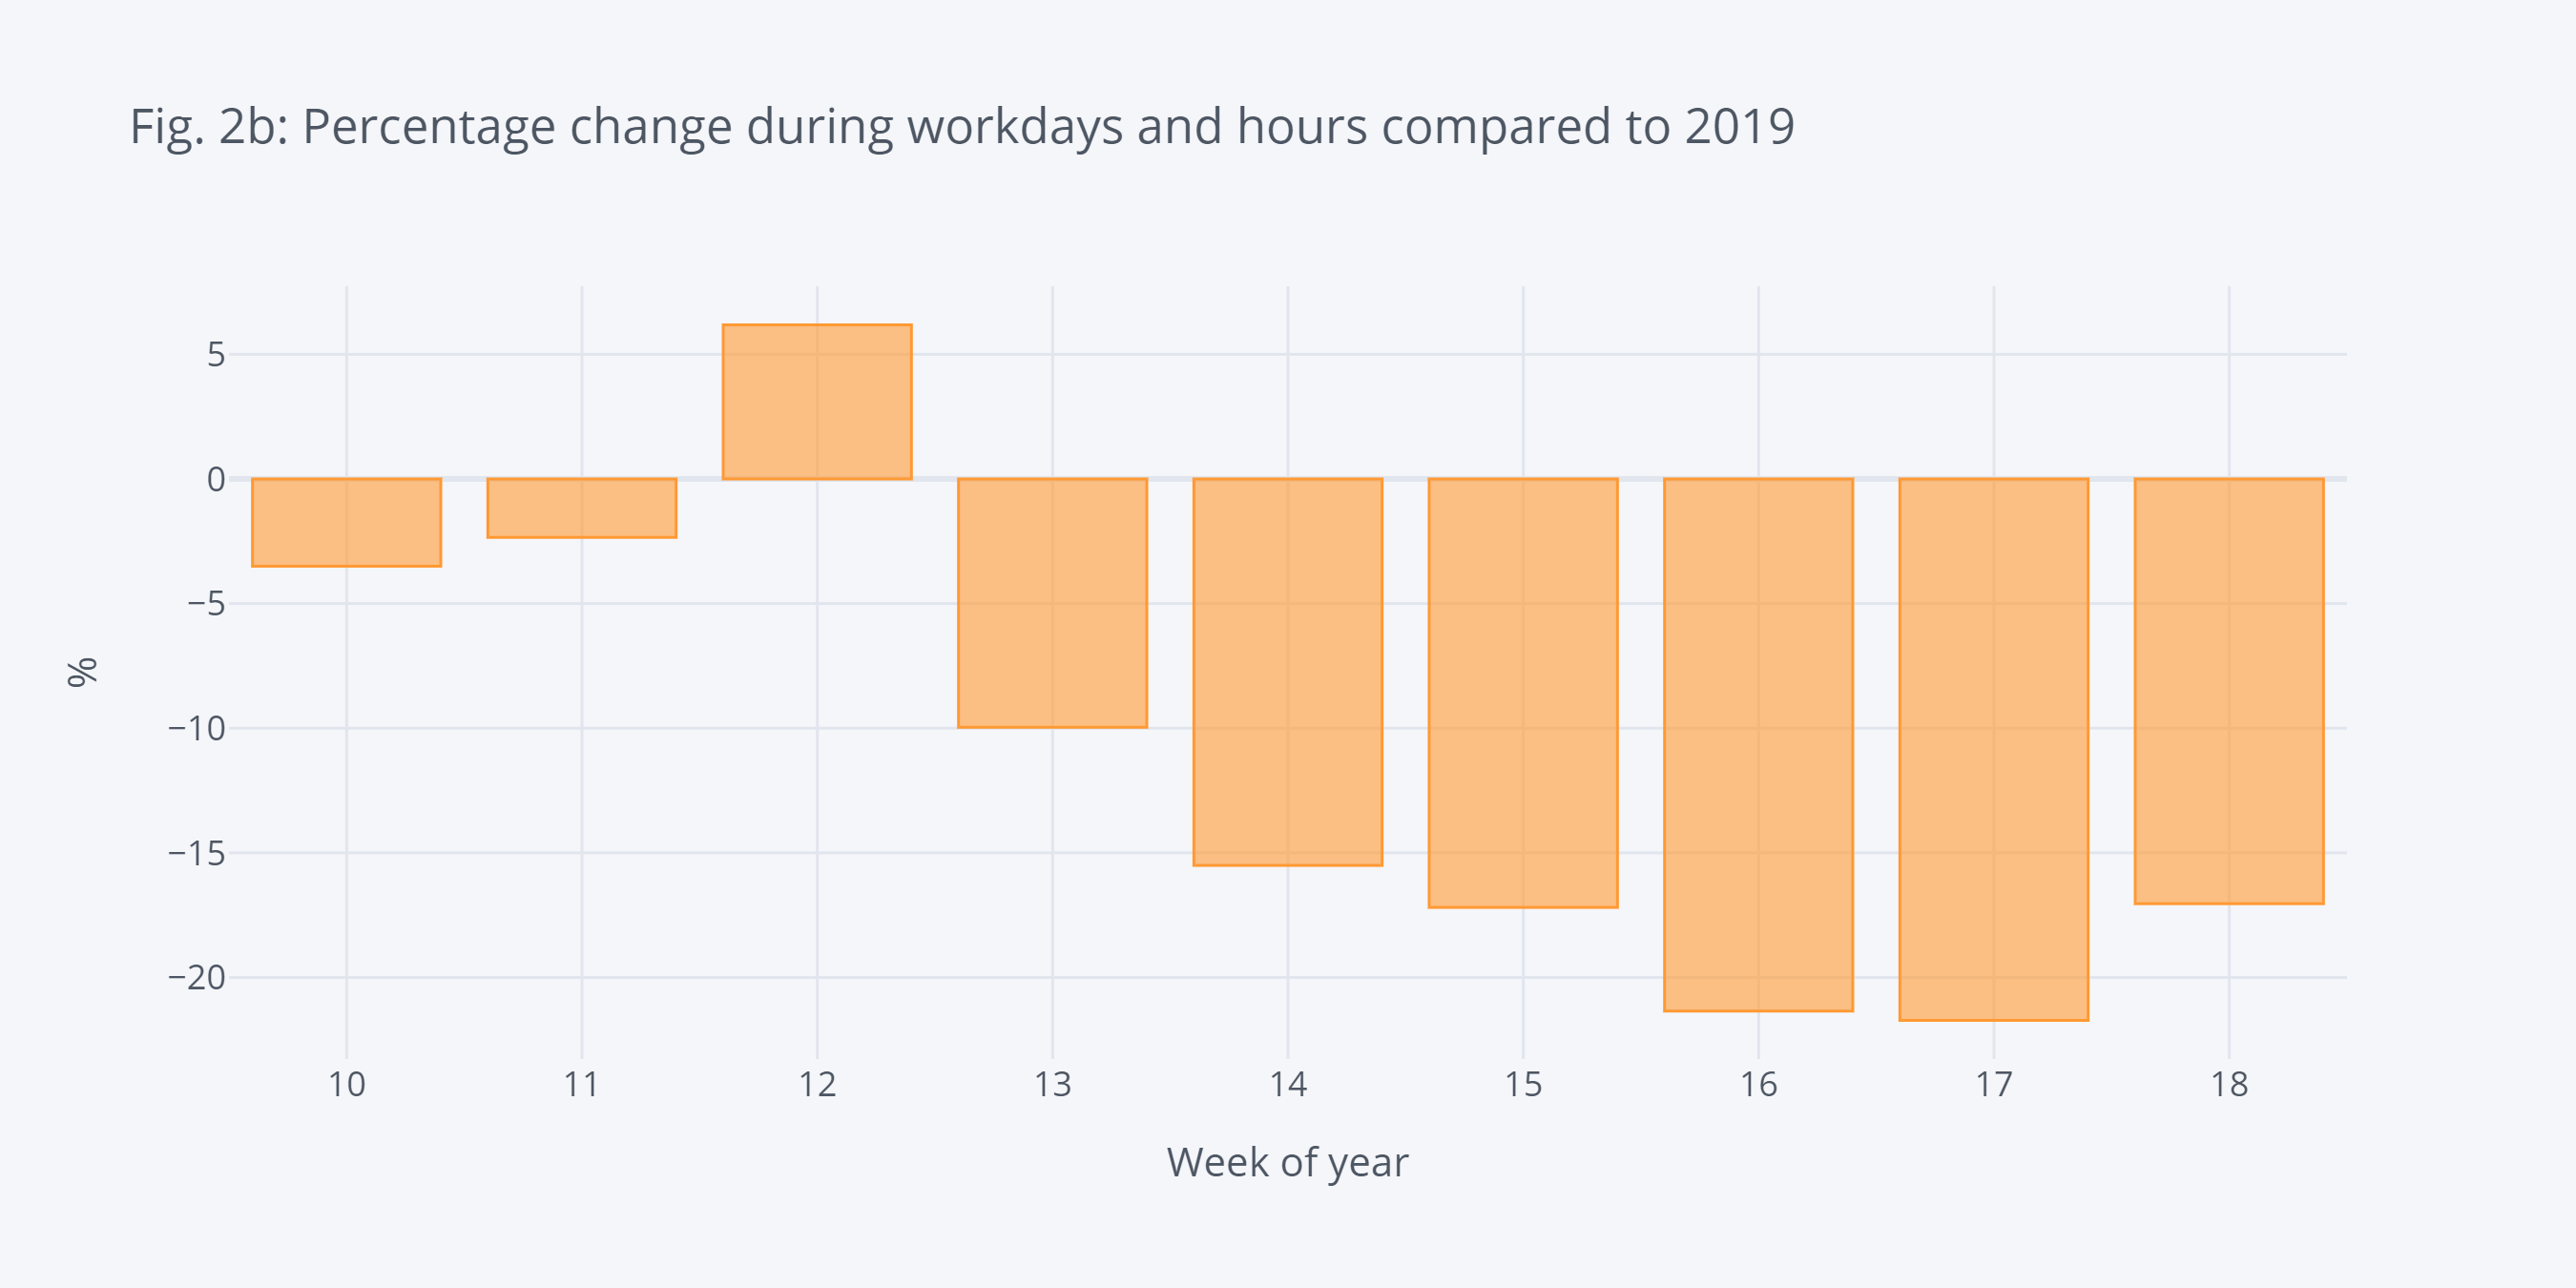

In [10]:
alldfWmean20['perc'] = ((alldfWmean20['LOAD20'] -alldfWmean19['LOAD19']) / alldfWmean19['LOAD19'])*100.0
fig = alldfWmean20.iplot(asFigure = True, kind='bar',xTitle='Week of year',yTitle='%',y='perc',title='Fig. 2b: Percentage change during workdays and hours compared to 2019')
if inPNG:
    fig.write_image("images/fig2b.png",height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig2b.png"))
else:
    fig.show()

To check if the decrease was due to a weather impact, we can use the Heating Degree Days. HDDs show by many degrees and for how long the temperature dropped below a specific threshold throughout the day. Thus, HDDs can be used to facilitate energy consumption comparisons between different years. From Fig. 3a, we can see that in week 15 we had precisely the same weekly HDDs. Thus the decrease cannot be assigned to the temperature differences.

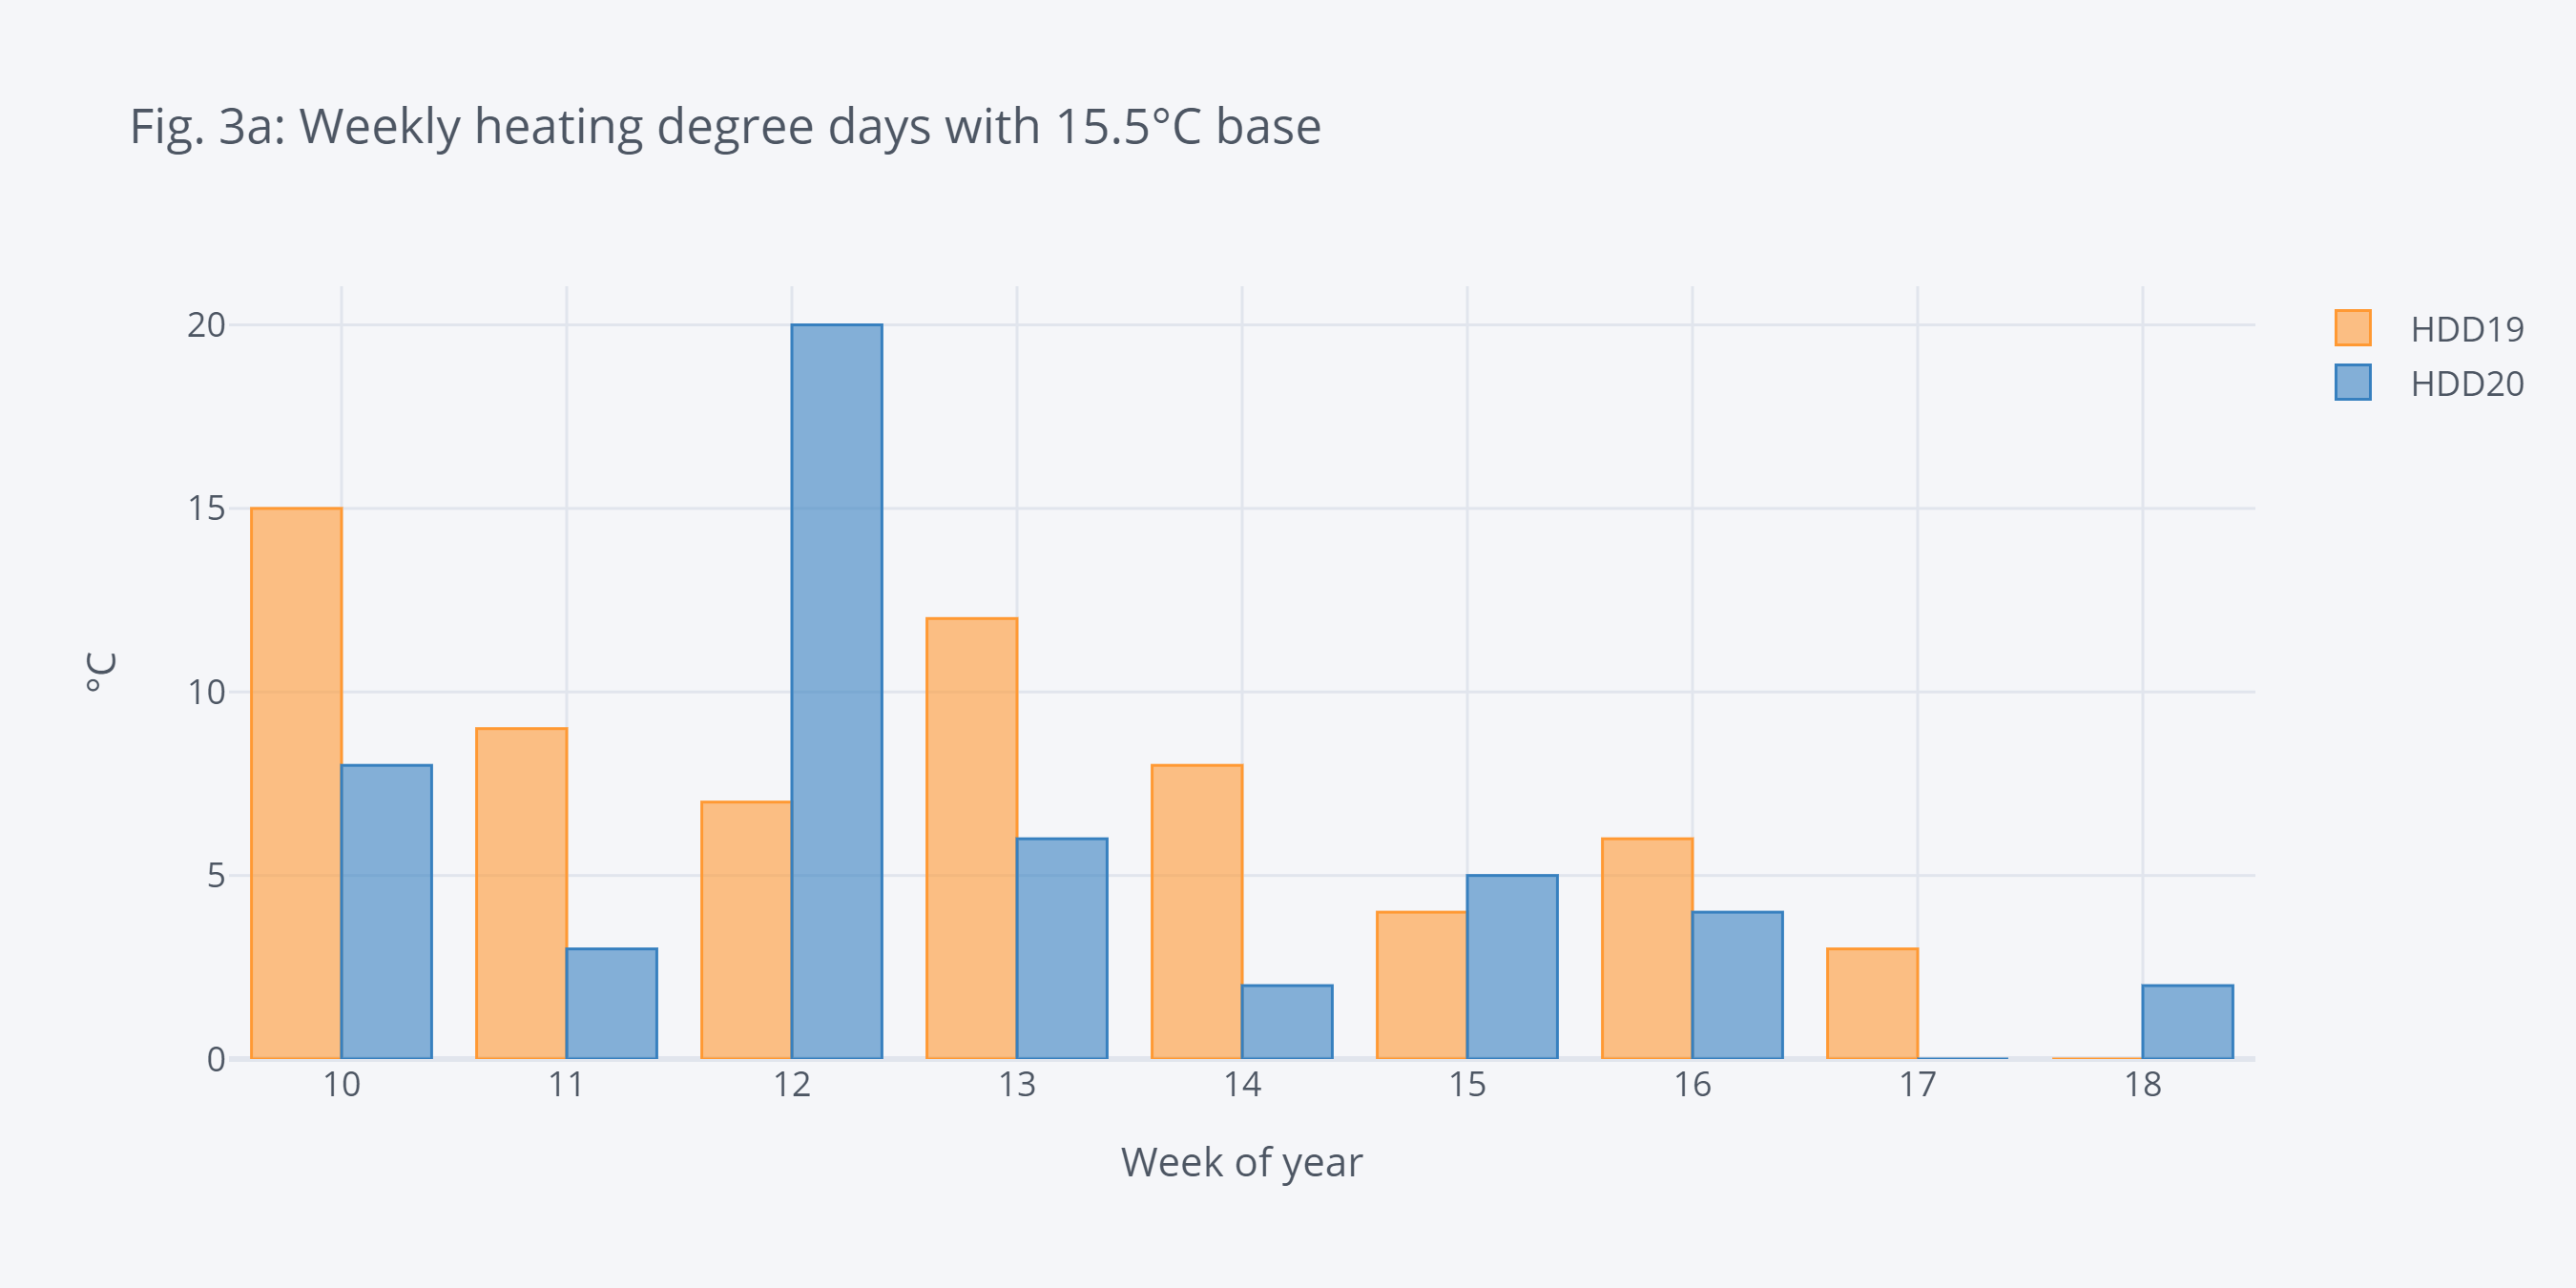

In [11]:
allHDD['week'] = allHDD.index.weekofyear
allHDD.set_index('week', inplace=True)
fig = allHDD.iplot(asFigure = True, kind='bar',y=['HDD19','HDD20'],xTitle='Week of year',yTitle='°C',title='Fig. 3a: Weekly heating degree days with 15.5°C base')
if inPNG:
    fig.write_image("images/fig3a.png",height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig3a.png"))
else:
    fig.show()

Since I had the load data and the HDDs, I decided to plot the correlation between them. Fig. 3b shows the *weekly HDDs* VS *weekly mean load* during the 8 weeks of interest in 2019. With this minimal dataset, it shows a nice linear correlation. Of course, to have something conclusive a full study needs to be made using multi-year data and taking into consideration other socio-economic factors. For this reason, above, I decided not to adjust the load profiles but compare weeks with same HDDs.

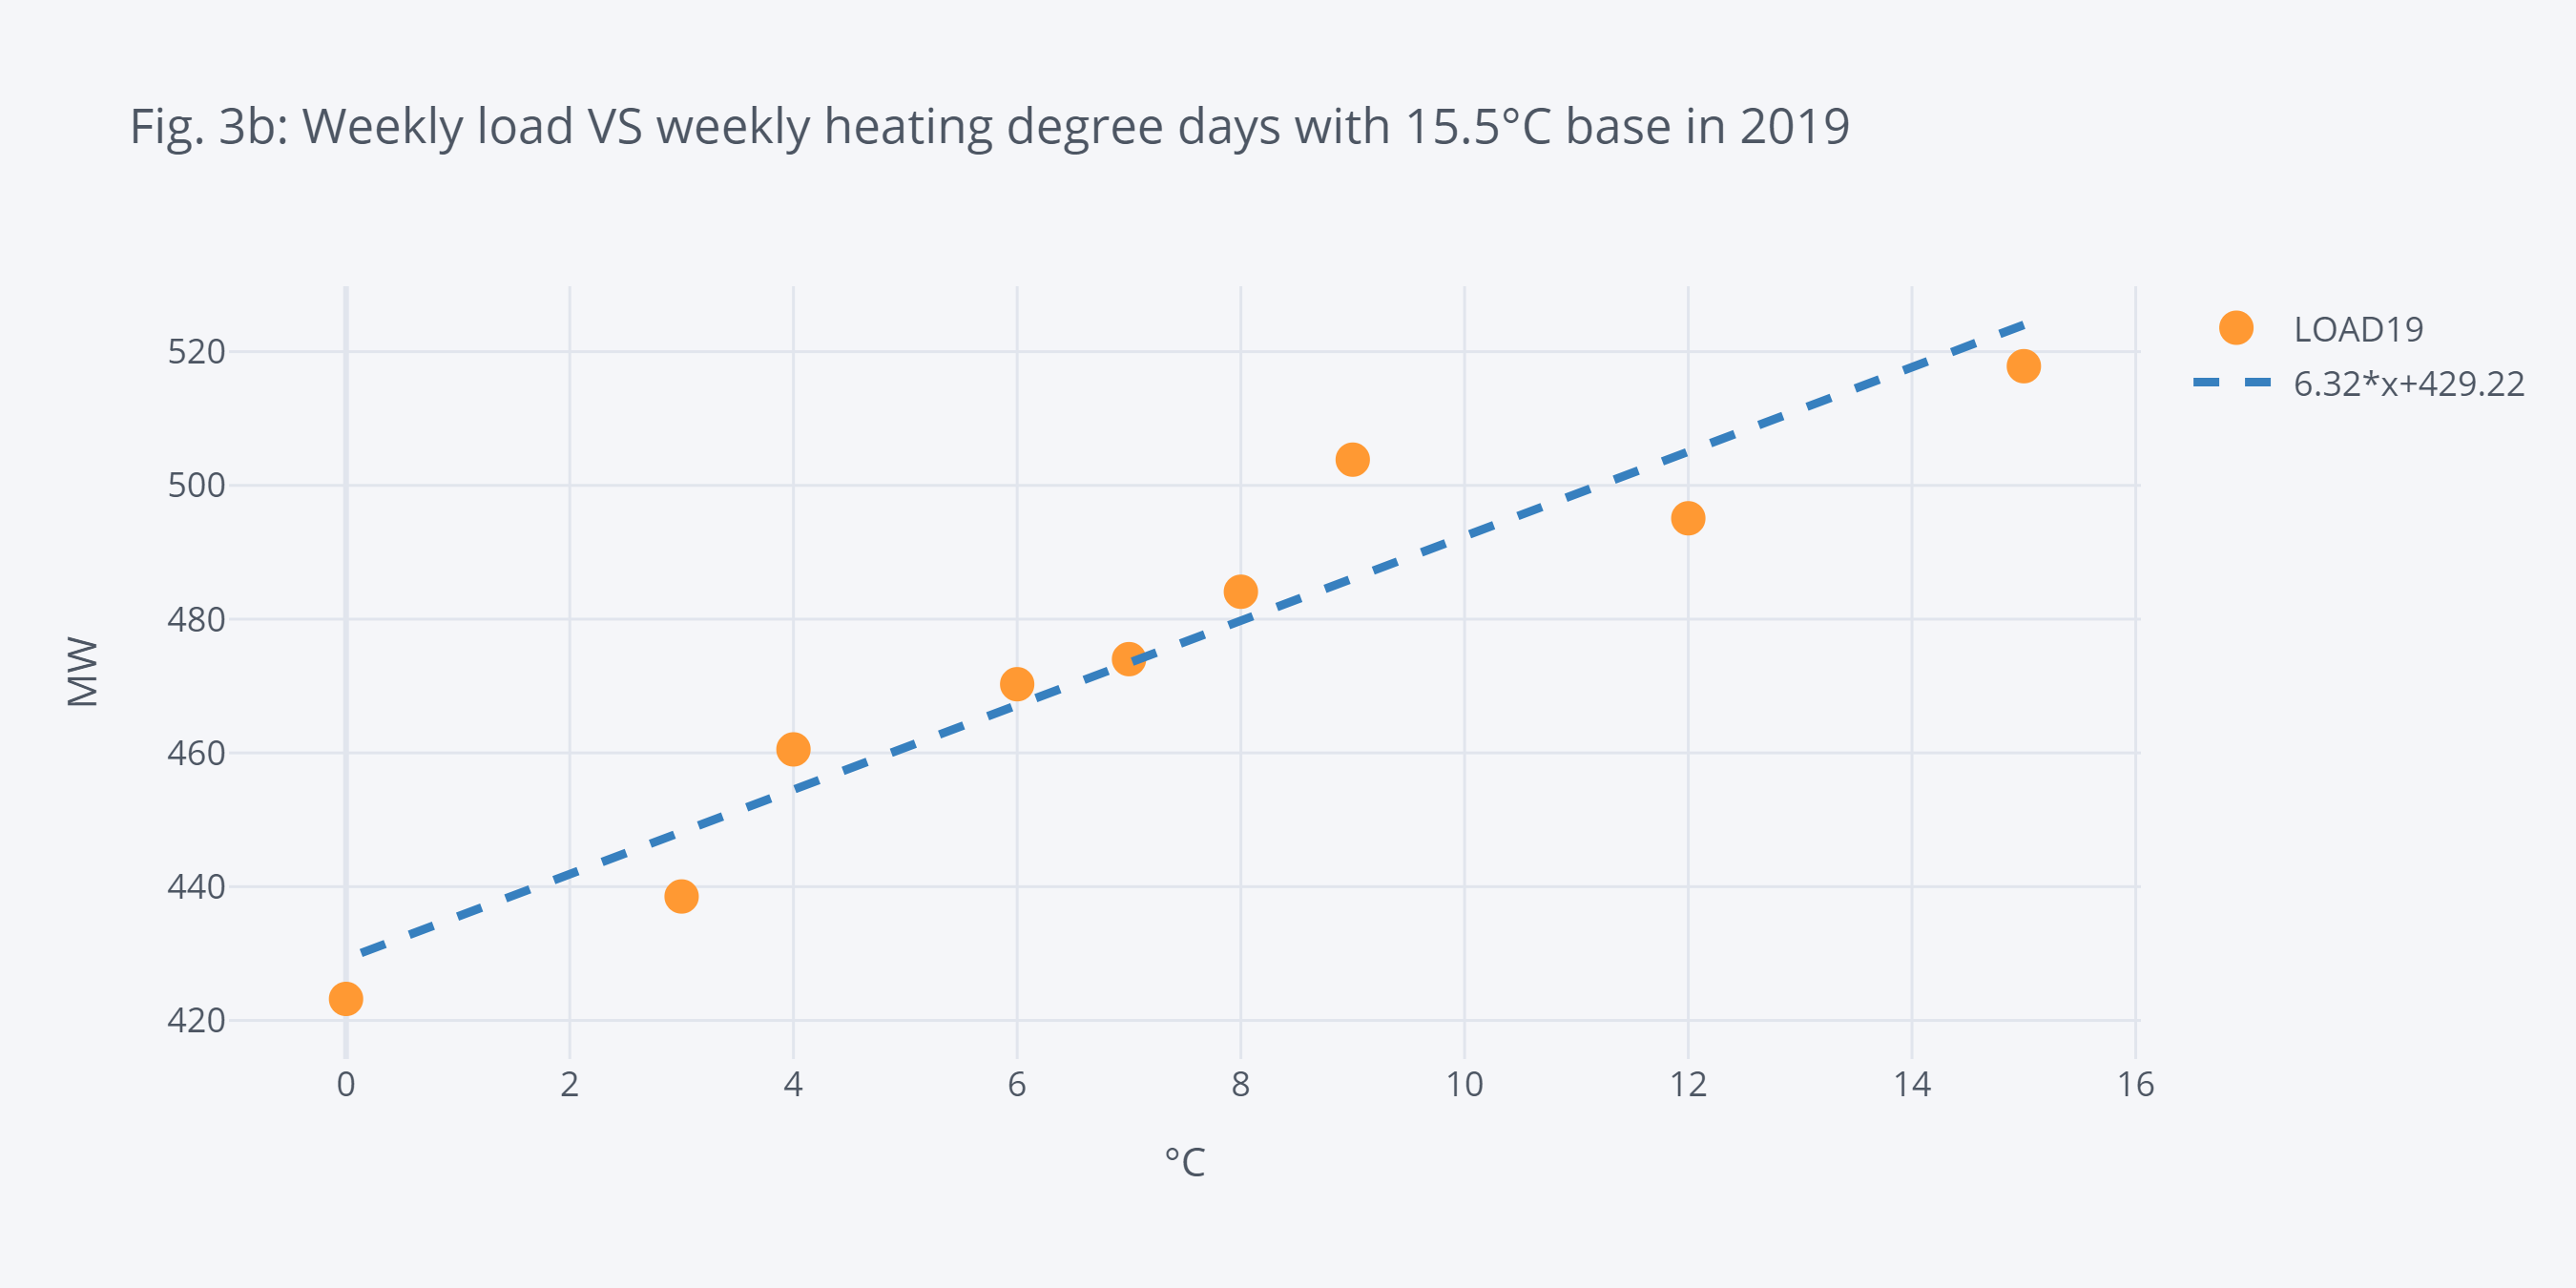

In [12]:
dfcorel = allHDD[['HDD19']].copy()
dfcorel = dfcorel.merge(alldfWmean[['LOAD19']], left_index=True, right_index=True)
fig = dfcorel.iplot(asFigure = True, mode='markers',y='LOAD19',x='HDD19',bestfit=True, bestfit_colors=['blue'],
               xTitle='°C',yTitle='MW',title='Fig. 3b: Weekly load VS weekly heating degree days with 15.5°C base in 2019')
if inPNG:
    fig.write_image("images/fig3b.png",height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig3b.png"))
else:
    fig.show()

## Impact on the load profile

Until now, I looked into the weekly mean power (or, equivalently weekly energy). I futher wanted to see if the shape of the load had changed. Fig. 4 shows the load profile for 2 workdays in April. We can see the two peaks (morning and afternoon). First one usually associated to commercial activities and the afternoon with leisure/home activities. We can again see the drecrease.

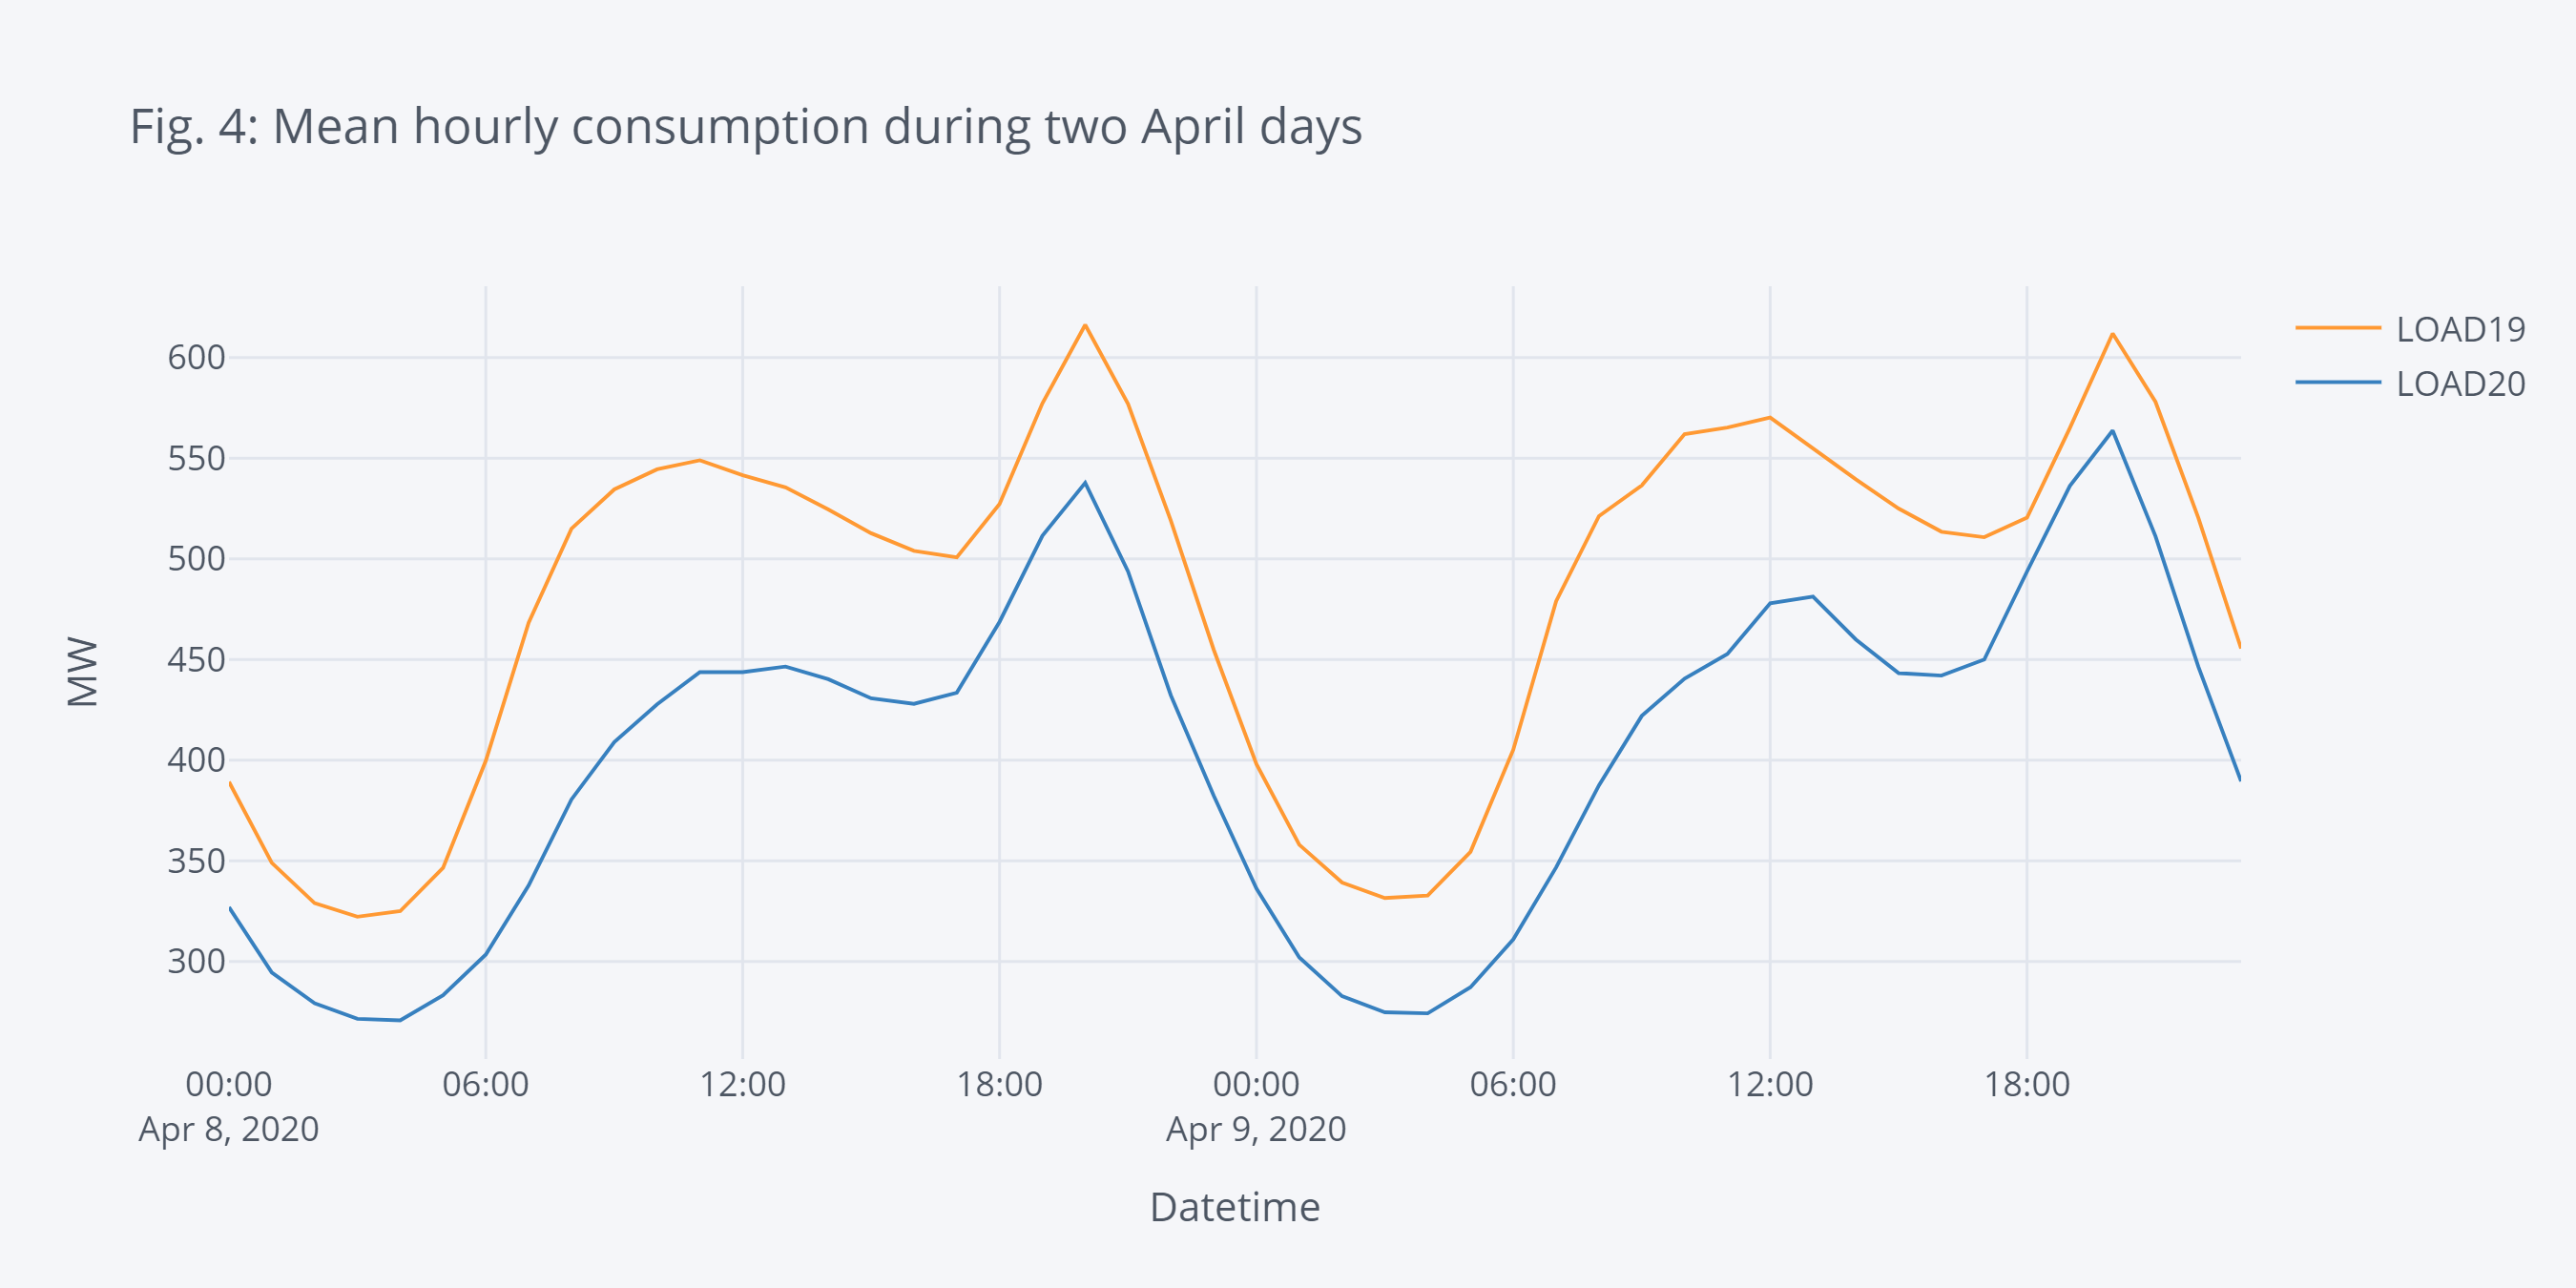

In [13]:
fig = alldf[(alldf.index.dayofyear >= 99) & (alldf.index.dayofyear <= 100)].resample('H').mean().iplot(asFigure = True, kind='lines',y=['LOAD19','LOAD20'],xTitle='Datetime',yTitle='MW',title='Fig. 4: Mean hourly consumption during two April days')
if inPNG:
    fig.write_image("images/fig4.png",height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig4.png"))
else:
    fig.show()

With the snapshot of the load profile above, it is not safe making observations. So, I decided to build the load profiles over the weeks 12-18 (after the lockdown) using Kmeans clustering technique. I know that it was probably an overkill to use Kmeans clustering to get a single averaged curve for each of the years. However, I wanted to practice using the Kmeans clustering tools, and the code can be easily modified to provide multiple representative days for prediction, planning, or operation tools. I had much help setting up the method from [this blog post](http://lucianogviola.com/data/energy_clustering/), you should read it if you are interested in clustering for energy.

What we can see from the clustered curves in Fig. 5 is that there is a definite decrease in load consumption but also a shift in the morning peak by almost two hours later. This should be expected since many people shifted to home-working during the lockdown and schools were closed. It meant a lot of the economic activity moved to later in the day. On the contrary, the afternoon peak seemed to be unaffected.

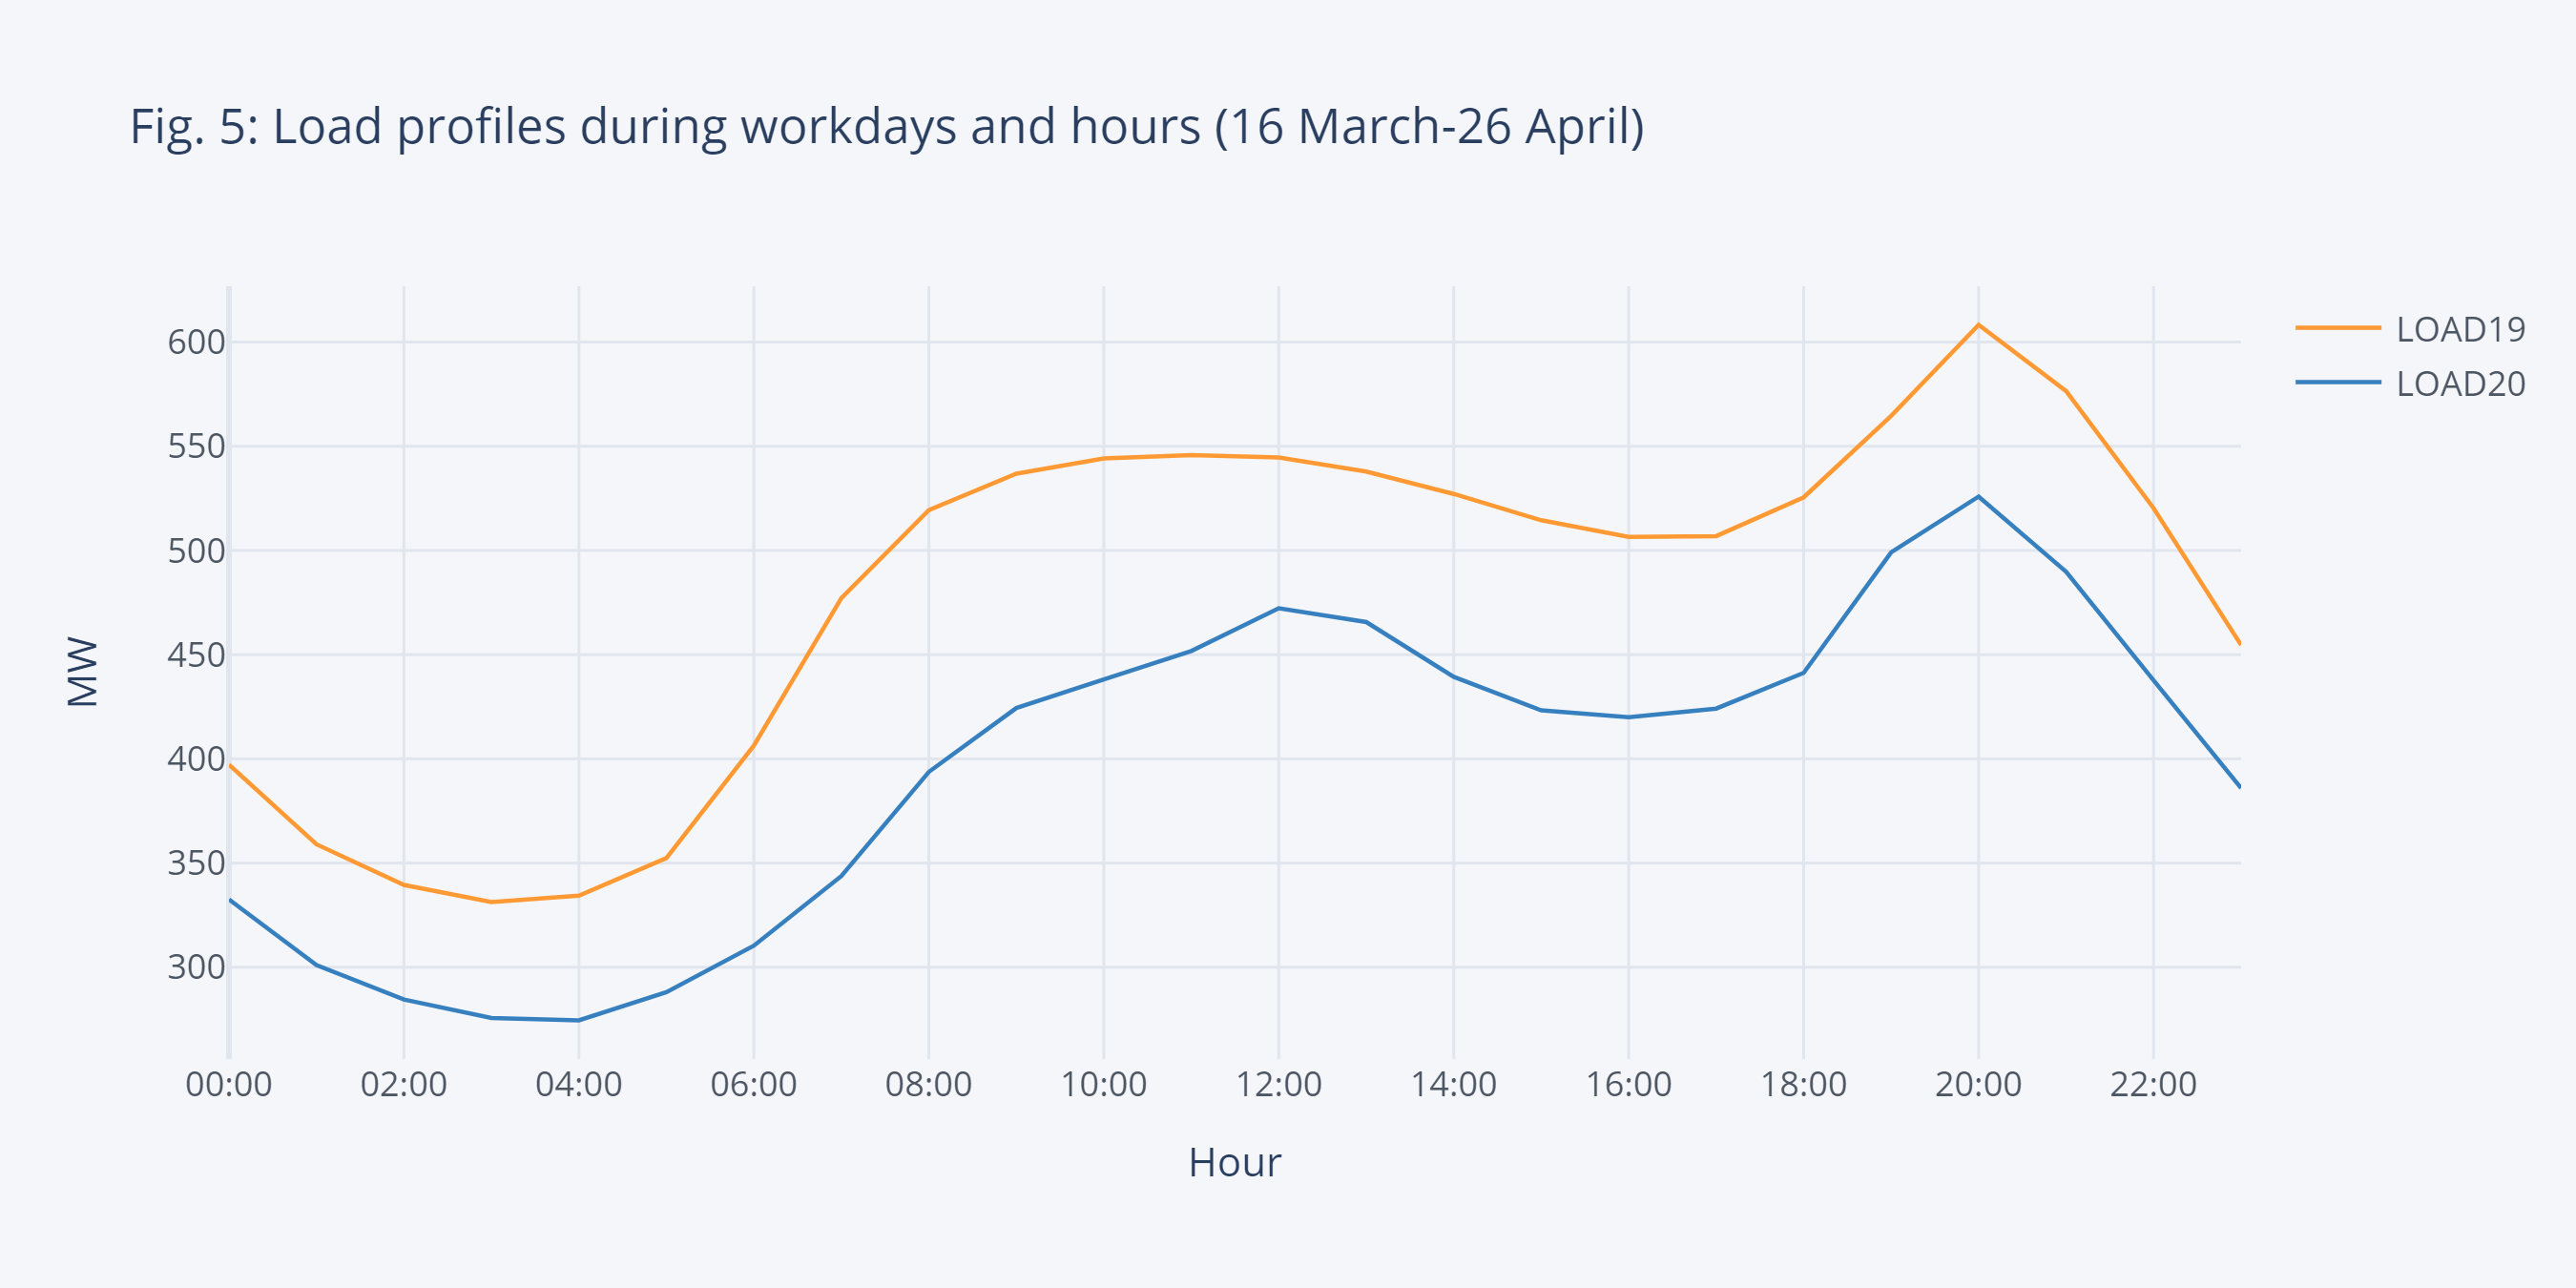

In [14]:
# The clustering method was based on http://lucianogviola.com/data/energy_clustering/
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Focus weeks 12-18. These are the dataframse with only workdays.
df19wd = df19wd[ (df19wd.index.weekofyear >= focusweek) ]
df20wd = df20wd[ (df20wd.index.weekofyear >= focusweek) ]
# Clean the dataframes and only keep the loads.
dbs = [df19wd.drop(['CAP','WIND','PV','CONV','PEN19'], axis=1), 
       df20wd.drop(['CAP','WIND','PV','CONV','PEN20'], axis=1)]
years = ['LOAD19','LOAD20']
first_run = True

for yr, df_tmp  in zip(years,dbs):
    
    # Make sure the df is clean from nans
    df_tmp = df_tmp.replace('?', np.nan)
    df_tmp = df_tmp.astype(np.float).fillna(method='bfill')
    
    # Get the hourly mean from the 15-minute intervals
    df_tmp_hourly = df_tmp.resample('H').mean()
    # Create new column with the hour of the day
    df_tmp_hourly['hour'] = df_tmp_hourly.index.hour
    # Set the index to be the date
    df_tmp_hourly.index = df_tmp_hourly.index.date

    # Pivot the df towards the hour of day and drop NaN values (didn't get any to be honest)
    df_tmp_pivot = df_tmp_hourly.pivot(columns='hour')
    df_tmp_pivot = df_tmp_pivot.dropna()

    # Get a copy of the pivotted df
    X = df_tmp_pivot.values.copy()

    # Scale the pivotted df
    sc = MinMaxScaler()
    X = sc.fit_transform(X)
    
    # Kmeans number of clusters (here just 1)
    kmeans = KMeans(n_clusters=1)
    cluster_found = kmeans.fit_predict(X)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    df_tmp_pivot = df_tmp_pivot.set_index(cluster_found_sr, append=True )
    cluster_values = sorted(df_tmp_pivot.index.get_level_values('cluster').unique())
    
    if first_run:
        myfig = df_tmp_pivot.xs(0, level=1).median().droplevel(level=0).iplot(asFigure = True)
        myfig.update_traces(name=yr,mode='lines',line=dict(width=1.5))
        first_run = False
    else:
        myfig.add_trace(go.Scatter(x=df_tmp_pivot.xs(0, level=1).median().index.droplevel(level=0),y=df_tmp_pivot.xs(0, level=1).median().values, mode='lines',name=yr,line=dict(width=1.5,color=cf.colors.hex_to_rgb('blue'))))

myfig.update_layout(title='Fig. 5: Load profiles during workdays and hours (16 March-26 April)',
                   xaxis_title='Hour',
                   yaxis_title='MW',
                   xaxis = dict(tickmode = 'array',
                        tickvals=list(np.arange(0,24,2)),
                        ticktext = [ dt.time(i).strftime('%H:%M') for i in np.arange(0,24,2)]),
                   showlegend=True)
if inPNG:
    myfig.write_image("images/fig5.png",height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig5.png"))
else:
    myfig.show()

## Renewable energy penetration and impact on the grid

Cyprus system is an islanded network and has actively been investing in the renewable generation (mainly PVs) over the last year. The rapid decrease in load consumption led the system to operate with high RES penetration. This is shown in Fig. 6, where an up to 54% penetration of RES was recorded. Moreover, during the under-study period, almost 18% of the total energy was covered by RES. These two might provide the only positive outcomes of the pandemic.

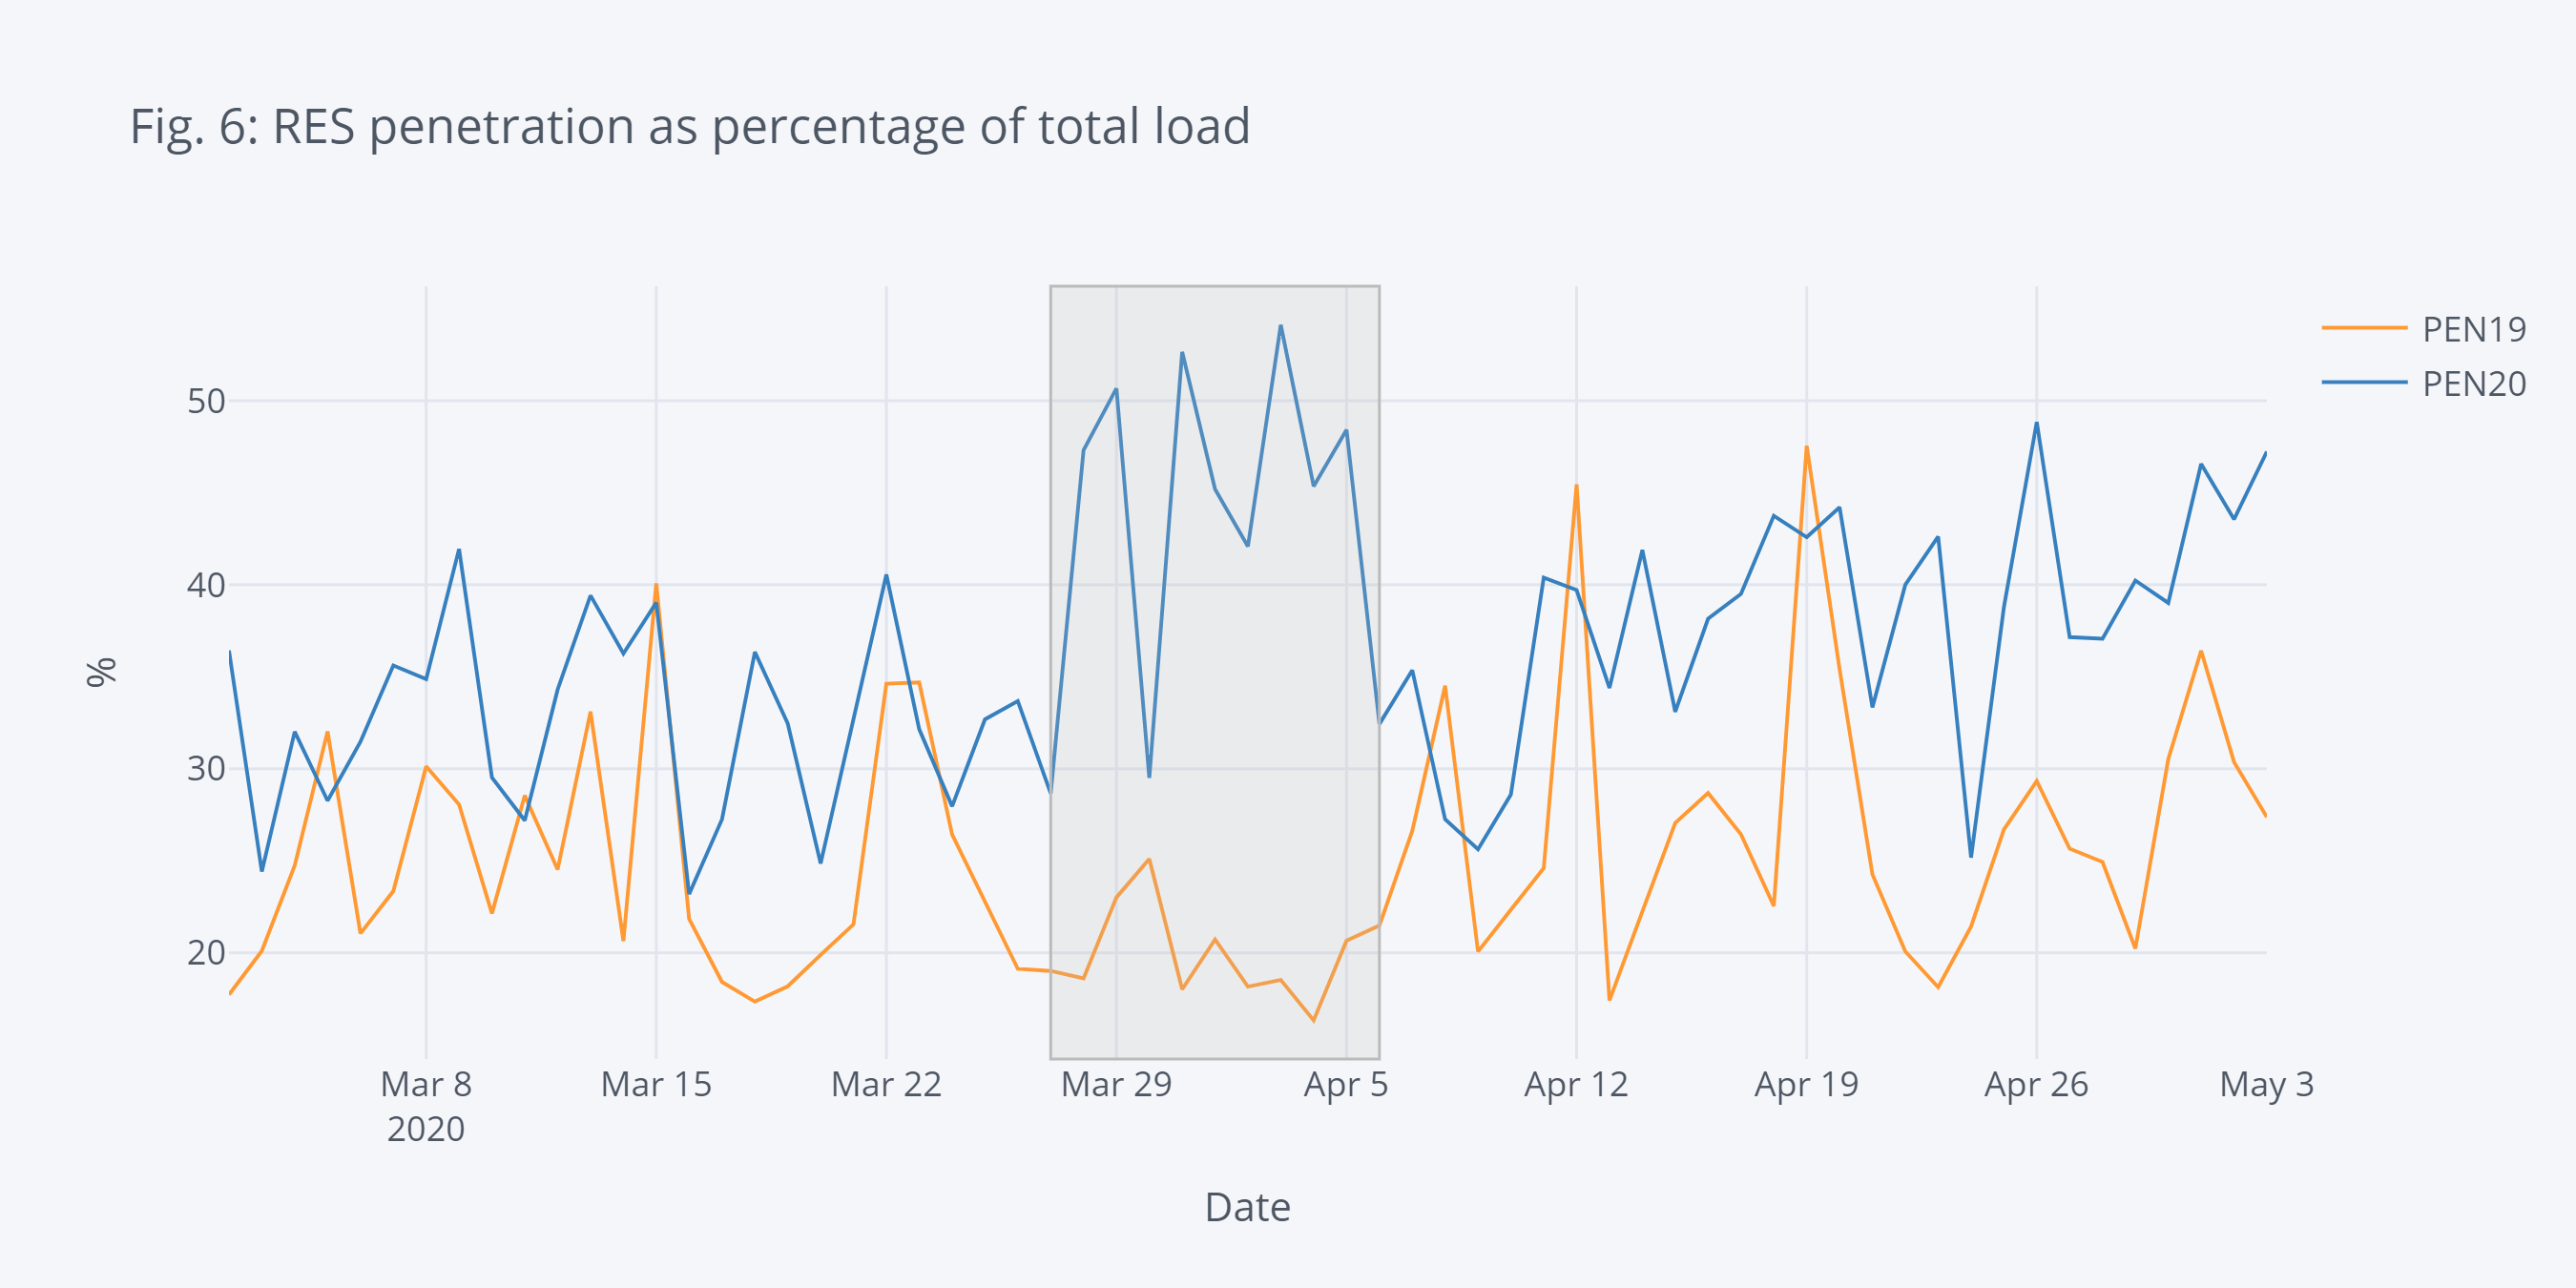

In [15]:
fig = alldf.resample('D').max().iplot(asFigure = True,
    kind='lines',y=['PEN19','PEN20'],xTitle='Date',
    yTitle='%',title='Fig. 6: RES penetration as percentage of total load',
    vspan={'x0':'2020-03-27','x1':'2020-04-06',
                      'color':'rgba(30,30,30,0.3)','fill':True,'opacity':.2})
if inPNG:
    fig.write_image("images/fig6.png",height = imheight, width = imwidth, scale = imscale)
    display(Image("images/fig6.png"))
else:
    fig.show()

However, the Cyprus system is islanded. Thus, high RES penetration creates many technical issues coming under the umbrella of [low-inertia problems](https://sps.cut.ac.cy/project/low-inertia/). Briefly, the rising RES generation and the decreasing load leads to many conventional generators (gas, oil, etc.) offline. Conventional generators though offer valuable services to the system (in addition to energy) that help the TSO keep the frequency and the voltage stable. RES doesn't usually provide these services (at least not at the moment). So, a high RES penetration might lead to decreased security for the system. For this reason, during this period, Cyprus had to partially shed some RES generation to maintain adequate levels of security.

I believe that this period, with high RES penetration, was a test-drive to see how the system will look like and how it can be operated in the future with high amounts of RES.


## Conclusion

Wrapping up, in this blog post, I used pandas and some freely available data to see what was the impact of COVID19 on energy consumption in Cyprus. The focus was put on the data and the tools, rather than the socio-economic implications. I believe this can provide a starting point if you want to analyse electricity data and trends. There are excellent books and tools in the area to help you get more in-depth. Just look into *Energy analytics* for books, posts, and research papers.

If you are interested in our group's research on low-inertia systems, please check [here](https://sps.cut.ac.cy/project/low-inertia/). Feel free to send any comments, bugs, or mistakes you find.